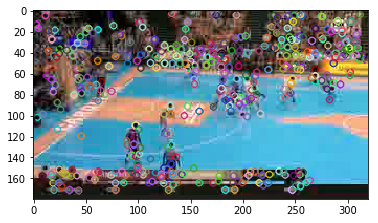

In [3]:
import cv2
import matplotlib.pyplot as plt

img = cv2.imread('./data/10034/jpg/320_180/thumb00053897.jpg',cv2.IMREAD_COLOR)
img = img
sift = cv2.xfeatures2d.SIFT_create(500)
key, desc = sift.detectAndCompute(img, None)
img = cv2.drawKeypoints(img, key, None)
plt.imshow(img)
plt.show()

In [ ]:
# create a BFMatcher object which will match up the SIFT features
img1 = cv2.imread('./data/10034/jpg/320_180/thumb00053897.jpg',cv2.IMREAD_COLOR)
img2 = cv2.imread('./data/10034/jpg/320_180/thumb00053899.jpg',cv2.IMREAD_COLOR)

bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

matches = bf.match(octo_front_desc, octo_offset_desc)

# Sort the matches in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)

# draw the top N matches
N_MATCHES = 100

match_img = cv2.drawMatches(
    octo_front, octo_front_kp,
    octo_offset, octo_offset_kp,
    matches[:N_MATCHES], octo_offset.copy(), flags=0)

plt.figure(figsize=(12,6))
plt.imshow(match_img);

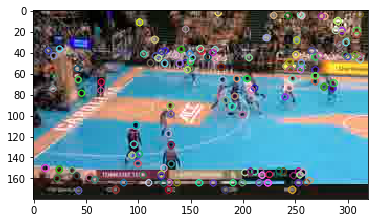

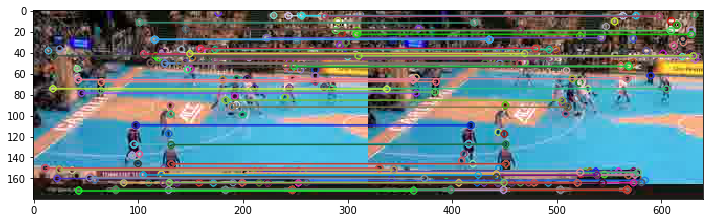

In [6]:

def show_rgb_img(img):
    """Convenience function to display a typical color image"""
    return plt.imshow(cv2.cvtColor(img, cv2.CV_32S))

def to_gray(color_img):
    gray = cv2.cvtColor(color_img, cv2.COLOR_BGR2GRAY)
    return gray


def gen_sift_features(gray_img):
    sift = cv2.xfeatures2d.SIFT_create(200)
    kp, desc = sift.detectAndCompute(gray_img, None)
    return kp, desc

def show_sift_features(gray_img, color_img, kp):
    return plt.imshow(cv2.drawKeypoints(gray_img, kp, color_img.copy()))

img1 = cv2.imread('./data/10034/jpg/320_180/thumb00053897.jpg',cv2.IMREAD_COLOR)
img2 = cv2.imread('./data/10034/jpg/320_180/thumb00053899.jpg',cv2.IMREAD_COLOR)

# img_1_gray = to_gray(img1)
# img_2_gray = to_gray(img2)

# generate SIFT keypoints and descriptors
img1_kp, img1_desc = gen_sift_features(img1)
img2_kp, img2_desc = gen_sift_features(img2)

img = cv2.drawKeypoints(img1, img1_kp, None)
plt.imshow(img)
# print('Here are what our SIFT features look like for the front-view octopus image:')
# show_sift_features(img1, img1_kp, None);

bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

matches = bf.match(img1_desc, img2_desc)

# Sort the matches in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)

# draw the top N matches
N_MATCHES = 100

match_img = cv2.drawMatches(
    img1, img1_kp,
    img2, img2_kp,
    matches[:N_MATCHES], img2.copy(), flags=0)

plt.figure(figsize=(12,6))
plt.imshow(match_img);

In [50]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras.models as M
import tensorflow.keras.optimizers as O
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
from tensorflow.keras.utils import Sequence
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import InceptionV3,preprocess_input
import cv2
import matplotlib.pyplot as plt


class CNN_Loader(Sequence):
    def __init__(self, img_paths, targets, batch_size):
        self.img_paths, self.targets = img_paths, targets
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.img_paths) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_imgs = self.img_paths[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.targets[idx * self.batch_size:(idx + 1) * self.batch_size]
        s_features = []
        for filename in batch_imgs:
            img = cv2.imread("data/"+filename, cv2.IMREAD_COLOR)
            blur = cv2.blur(img,(50,50))
            blur2 = cv2.GaussianBlur(img,(3,3),0)
#             desc_shape = np.zeros((25600,1))
            absd=cv2.equalizeHist(cv2.cvtColor(cv2.absdiff(blur2,blur),cv2.COLOR_BGR2GRAY))
    #         plt.imshow(absd)
    #         plt.show()
            saliency = cv2.saliency.StaticSaliencyFineGrained_create()
            (success, saliencyMap) = saliency.computeSaliency(absd)

            threshMap = cv2.threshold(saliencyMap.astype("uint8"), 0, 255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
            ss = saliencyMap.copy()
            ss[:40, :] = 0
            ss[:, :20] = 0
            ss[:, -20:] = 0
            sift1 = cv2.xfeatures2d.SIFT_create(200)
            kp1, desc = sift1.detectAndCompute(ss, None)
            f = desc.flatten()
            s_features.append(f[:25600])
        for i in range(len(s_features)):
            s_features[i] = s_features[i][:25600] 
#         for i in s_features:
#             if len(i) > 25600 or len(i) < 25600:
#                 print(len(i))
        s_features = np.asarray(s_features)
        return s_features[:,:25600], np.array(batch_y)
        
    
    def gen_surf_features(self,gray_img):
        sift = cv2.xfeatures2d.SURF_create(1000)
        kp, desc = sift.detectAndCompute(gray_img, None)
        return desc.ravel().reshape(-1,1)
    
    def gen_orb_features(self,gray_img):
        sift = cv2.ORB_create(200)
        kp, desc = sift.detectAndCompute(gray_img, None)
        return desc.ravel().reshape(-1,1)
    

In [51]:
def weighted_binary_crossentropy(y_true, y_pred):

    # Original binary crossentropy (see losses.py):
    # K.mean(K.binary_crossentropy(y_true, y_pred), axis=-1)

    # Calculate the binary crossentropy
    b_ce = K.binary_crossentropy(y_true, y_pred)

    # Apply the weights
    weight_vector = y_true * 0.9 + (1. - y_true) * 0.1
    weighted_b_ce = weight_vector * b_ce

    # Return the mean error
    return K.mean(weighted_b_ce)

In [52]:
def build_model():
    
    i1 = L.Input(shape=(200*128))
    
    x1 = L.Dense(64, activation='relu')(i1)
    x1 = L.Dense(128, activation='relu')(x1)
    x1 = L.Dense(256, activation='relu')(x1)
    
    
#     x = L.Concatenate()([x1,x2,x3])
    x = L.Dense(32, activation='relu')(x1)
    predictions = L.Dense(1, activation='sigmoid')(x)
    model = M.Model(inputs=[i1], outputs=[predictions])
    adam = O.Adam(learning_rate=0.01)
    model.compile(optimizer=adam, loss=weighted_binary_crossentropy, metrics=['accuracy'])
    return model

def training_model(train_data_gen, model):
    model.fit_generator(train_data_gen, epochs=50)
    return model

def evaluate_model(eval_data_gen, model):
    scores=model.evaluate_generator(eval_data_gen)
    print(scores)

In [53]:
def data_train_test(data, split=0.7):
    train_split = int(split*data.shape[0])
    x_train,y_train = data.iloc[:train_split,0].values, data.iloc[:train_split,1].astype('int').values
    x_test,y_test = data.iloc[train_split:,0].values, data.iloc[train_split:,1].astype('int').values
    return x_train, y_train, x_test, y_test

In [54]:
model = build_model()
model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 25600)]           0         
_________________________________________________________________
dense_30 (Dense)             (None, 64)                1638464   
_________________________________________________________________
dense_31 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_32 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_33 (Dense)             (None, 32)                8224      
_________________________________________________________________
dense_34 (Dense)             (None, 1)                 33        
Total params: 1,688,065
Trainable params: 1,688,065
Non-trainable params: 0
_________________________________________________

In [55]:
data = pd.read_csv("./data/jumpball_training_data.csv")
data=data.sample(frac=1)
x_train, y_train, x_test, y_test = data_train_test(data, 0.6)

In [56]:
train_data_gen = CNN_Loader(x_train, y_train, 64)
eval_data_gen = CNN_Loader(x_test, y_test, 64)

In [57]:
model = training_model(train_data_gen, model)

Epoch 1/50
 3/85 [>.............................] - ETA: 5:35 - loss: 320.8290 - acc: 0.5417

IndexError: too many indices for array

In [ ]:
a = np.zeros((200,128))
a = a.ravel().reshape(-1,1)
b = a.ravel().reshape(-1,1)
c = a.ravel().reshape(-1,1)

In [65]:
x = np.asarray([a,b])
y = np.asarray([b,c])
z = np.asarray([c,a])

cc = np.vstack((x,y,z))
cc.shape

(6, 25600, 1)

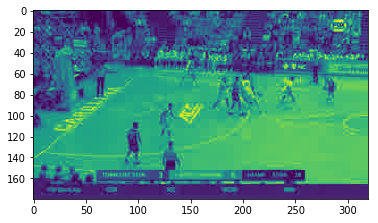

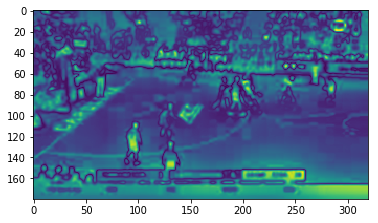

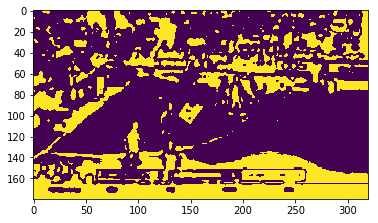

In [2]:
# initialize OpenCV's static fine grained saliency detector and
# compute the saliency map
import cv2
import matplotlib.pyplot as plt

img1 = cv2.imread('./data/10034/jpg/320_180/thumb00053899.jpg',cv2.IMREAD_GRAYSCALE)
saliency = cv2.saliency.StaticSaliencyFineGrained_create()
(success, saliencyMap) = saliency.computeSaliency(img1)
 
# if we would like a *binary* map that we could process for contours,
# compute convex hull's, extract bounding boxes, etc., we can
# additionally threshold the saliency map
threshMap = cv2.threshold(saliencyMap.astype("uint8"), 0, 255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

# show the images
plt.imshow(img1)
plt.show()
plt.imshow(saliencyMap)
plt.show()
plt.imshow(threshMap)
plt.show()

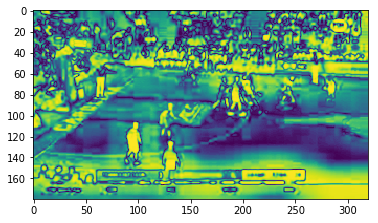

0 8 7 16


(2, 25600)

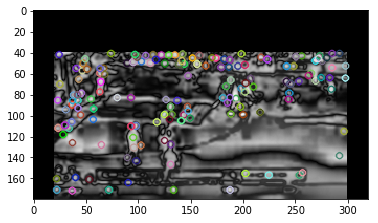

In [420]:
# kernel = np.ones((5,5),np.float32)/25
# dst = cv2.filter2D(img,-1,kernel)

# plt.subplot(121),plt.imshow(img),plt.title('Original')
# plt.xticks([]), plt.yticks([])
# plt.subplot(122),plt.imshow(dst),plt.title('Averaging')
# plt.xticks([]), plt.yticks([])
# plt.show()


# img = img1
# blur = cv2.GaussianBlur(img,(50,50),0)

# plt.subplot(121),plt.imshow(img),plt.title('Original')
# plt.xticks([]), plt.yticks([])
# plt.subplot(122),plt.imshow(blur),plt.title('Blurred')
# plt.xticks([]), plt.yticks([])
# plt.show()


blur = cv2.blur(img1,(50,50))
blur2 = cv2.GaussianBlur(img1,(3,3),0)

absd=cv2.equalizeHist(cv2.cvtColor(cv2.absdiff(blur2,blur),cv2.COLOR_BGR2GRAY))
plt.imshow(absd)
plt.show()
# absd.shape
saliency = cv2.saliency.StaticSaliencyFineGrained_create()
(success, saliencyMap) = saliency.computeSaliency(absd)
 
# if we would like a *binary* map that we could process for contours,
# compute convex hull's, extract bounding boxes, etc., we can
# additionally threshold the saliency map
threshMap = cv2.threshold(saliencyMap.astype("uint8"), 0, 255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
 
print(cv2.THRESH_BINARY, cv2.THRESH_OTSU, cv2.THRESH_MASK, cv2.THRESH_TRIANGLE)
# show the images
# plt.imshow(blur2)
# plt.show()
# plt.imshow(saliencyMap)
# plt.show()
# plt.imshow(threshMap)
# plt.show()
# saliencyMap.shape
ss = saliencyMap.copy()
ss[:40, :] = 0
ss[:, :20] = 0
ss[:, -20:] = 0
# plt.imshow(ss)
sift1 = cv2.xfeatures2d.SIFT_create(200)
kp1, desc = sift1.detectAndCompute(ss, None)
i = cv2.drawKeypoints(ss, kp1, None)
plt.imshow(i)

ad = []
ad.append(desc.ravel())
ad.append(desc.ravel())
np.asarray(ad).shape

In [293]:
desc.shape

(201, 128)

In [5]:
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    cm = confusion_matrix(y_true, y_pred)
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

plot_confusion_matrix(y_test, y_pred, classes=class_names, title='Confusion matrix')

plt.show()

NameError: name 'y_test' is not defined